# Data Visualization - Fórmula 1

Este notebook carrega os CSVs de Data Layer/raw/dados_originais, trata lap_times.csv como fato e as demais como dimensões, e gera gráficos de barras, pizza, regressão e análise de outliers.

### Configuração do ambiente (Spark/Java)
- - Objetivo: preparar ambiente visual e garantir Java 17 + sessão Spark local.
- - Ações: aplica tema gráfico, força `JAVA_HOME` e configura `PATH`.
- - Saída: variáveis de ambiente setadas e `spark` (construtor) pronto.
- - Observação: unidades nos gráficos em segundos (s).

In [97]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

os.environ['HADOOP_HOME'] = 'C:\\hadoop'
sys.path.append('C:\\hadoop\\bin')

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, concat_ws, when, avg, min, split, count as spark_count

spark = SparkSession.builder \
    .appName("AnaliseETL-DataViz") \
    .master("local[*]") \
    .config("spark.driver.host", "127.0.0.1") \
    .getOrCreate()


### Carregamento dos dados (CSV → Spark DataFrames)  
- **Objetivo:** carregar arquivos originais para análise.  
- **Ações:** define base path e lê todos os `.csv` com inferência de schema.  
- **Saída:** dicionário `dataframes` com 10 tabelas carregadas.  


In [98]:
base_path = "C:/Users/Shadown/formula1-analytics/Data Layer/raw/dados_originais"
file_names = [
    "circuits", "constructors", "drivers", "lap_times", "pit_stops",
    "qualifying", "races", "results", "status", "sprint_results"
]
dataframes = {}
try:
    for name in file_names:
        file_path = f"{base_path}/{name}.csv"
        dataframes[name] = spark.read.csv(file_path, header=True, inferSchema=True, nullValue="\\N")
except Exception as e:
    print(f"\nERRO AO CARREGAR OS ARQUIVOS. Verifique o caminho base.")
    spark.stop()
    exit()

### Configuração global de estilo (Seaborn/Matplotlib)  
- **Objetivo:** aplicar tema visual uniforme para todos os gráficos.  
- **Ações:** usa tema `whitegrid` e paleta `deep`.  
- **Saída:** gráficos mais legíveis e consistentes.  

In [99]:
sns.set_theme(style="whitegrid", palette="deep")

### Gráfico 1 – Boxplot dos tempos de volta por corrida (Top 5)  
- **Objetivo:** identificar outliers e dispersão nos tempos de volta.  
- **Ações:** seleciona top 5 corridas por nº de voltas registradas.  
- **Saída:** boxplot horizontal por corrida (em segundos).  
- **Insight esperado:** voltas muito lentas podem indicar erro, pit stop ou acidente. 

C:\Users\Shadown\AppData\Local\Temp\ipykernel_29628\983825331.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y="race_event_label", x="seconds", data=plot_data_1, orient='h', whis=[5, 95], palette="viridis")


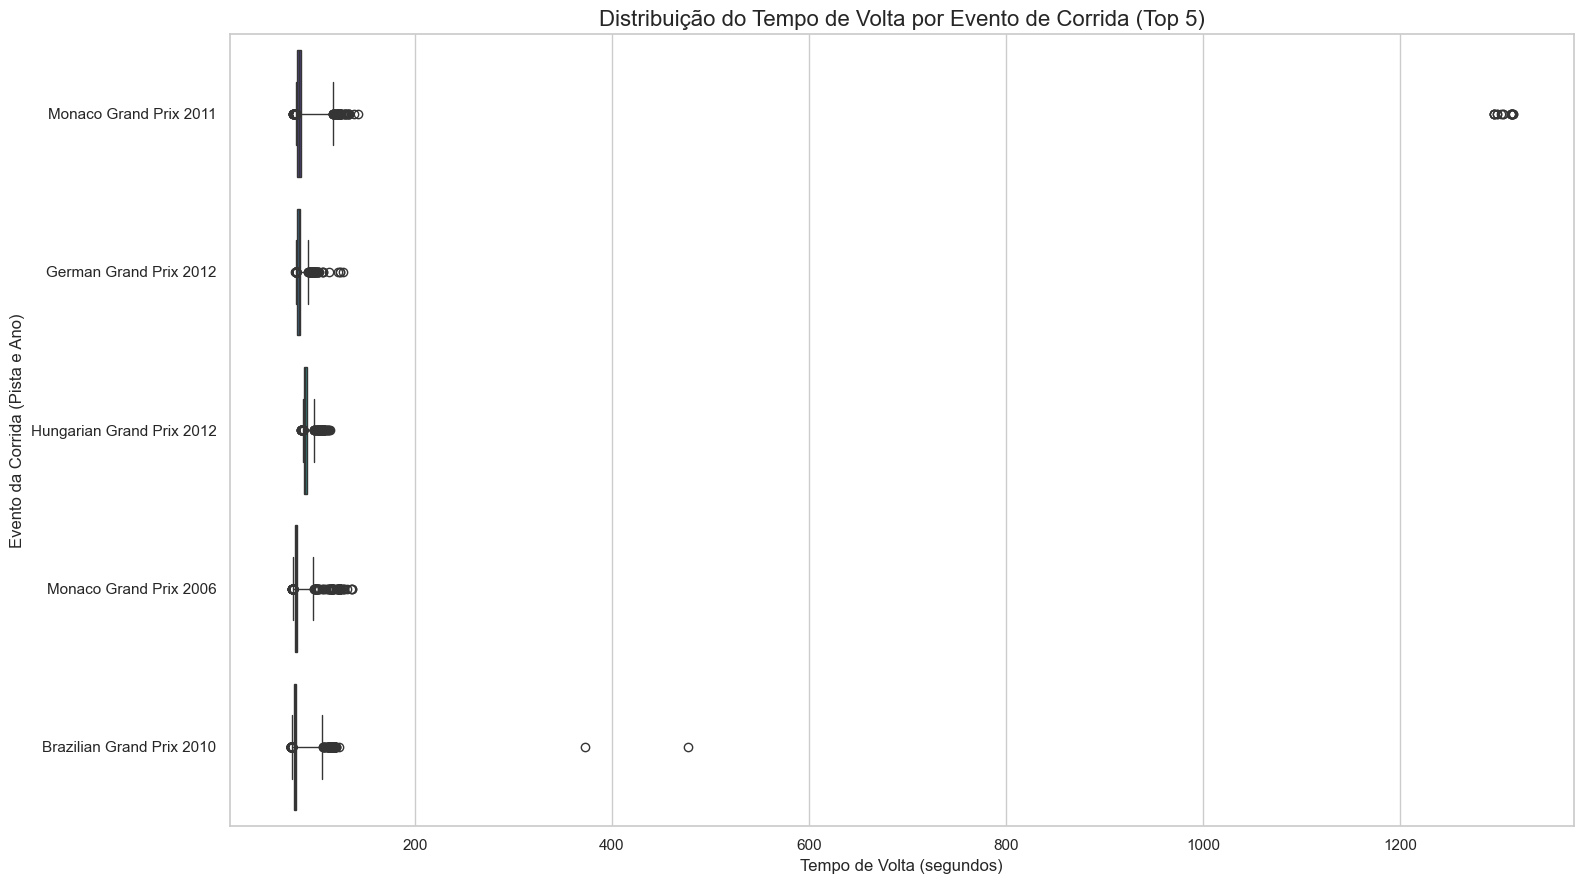

In [100]:
top_5_races_laps = dataframes['lap_times'].groupBy("raceId").count().orderBy(col("count").desc()).limit(5)
races_with_label = dataframes['races'].withColumn("race_event_label", concat_ws(" ", col("name"), col("year")))
lap_times_races_df = dataframes['lap_times'] \
    .join(top_5_races_laps, "raceId", "inner") \
    .join(races_with_label, "raceId", "left") \
    .withColumn("seconds", col("milliseconds") / 1000)
plot_data_1 = lap_times_races_df.select("race_event_label", "seconds").toPandas()
plt.figure(figsize=(16, 9))
sns.boxplot(y="race_event_label", x="seconds", data=plot_data_1, orient='h', whis=[5, 95], palette="viridis")
plt.title('Distribuição do Tempo de Volta por Evento de Corrida (Top 5)', fontsize=16)
plt.ylabel('Evento da Corrida (Pista e Ano)', fontsize=12)
plt.xlabel('Tempo de Volta (segundos)', fontsize=12)
plt.tight_layout()
plt.show()

### Gráfico 2 – Distribuição de Tempos de Volta em Mônaco  
- **Objetivo:** analisar a distribuição e consistência dos tempos dos 15 pilotos mais experientes em Mônaco.  
- **Ações:** filtra os tempos de Mônaco para os 15 pilotos com mais voltas e plota um boxplot para cada um.  
- **Saída:** boxplot comparando a distribuição de tempos, mostrando mediana, quartis e outliers por piloto.  
- **Insight esperado:** permite comparar a velocidade (mediana) e a consistência (tamanho da caixa) entre os pilotos.

C:\Users\Shadown\AppData\Local\Temp\ipykernel_29628\833016494.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=plot_data_2, y="driver_name", x="seconds", orient='h', palette="magma_r")


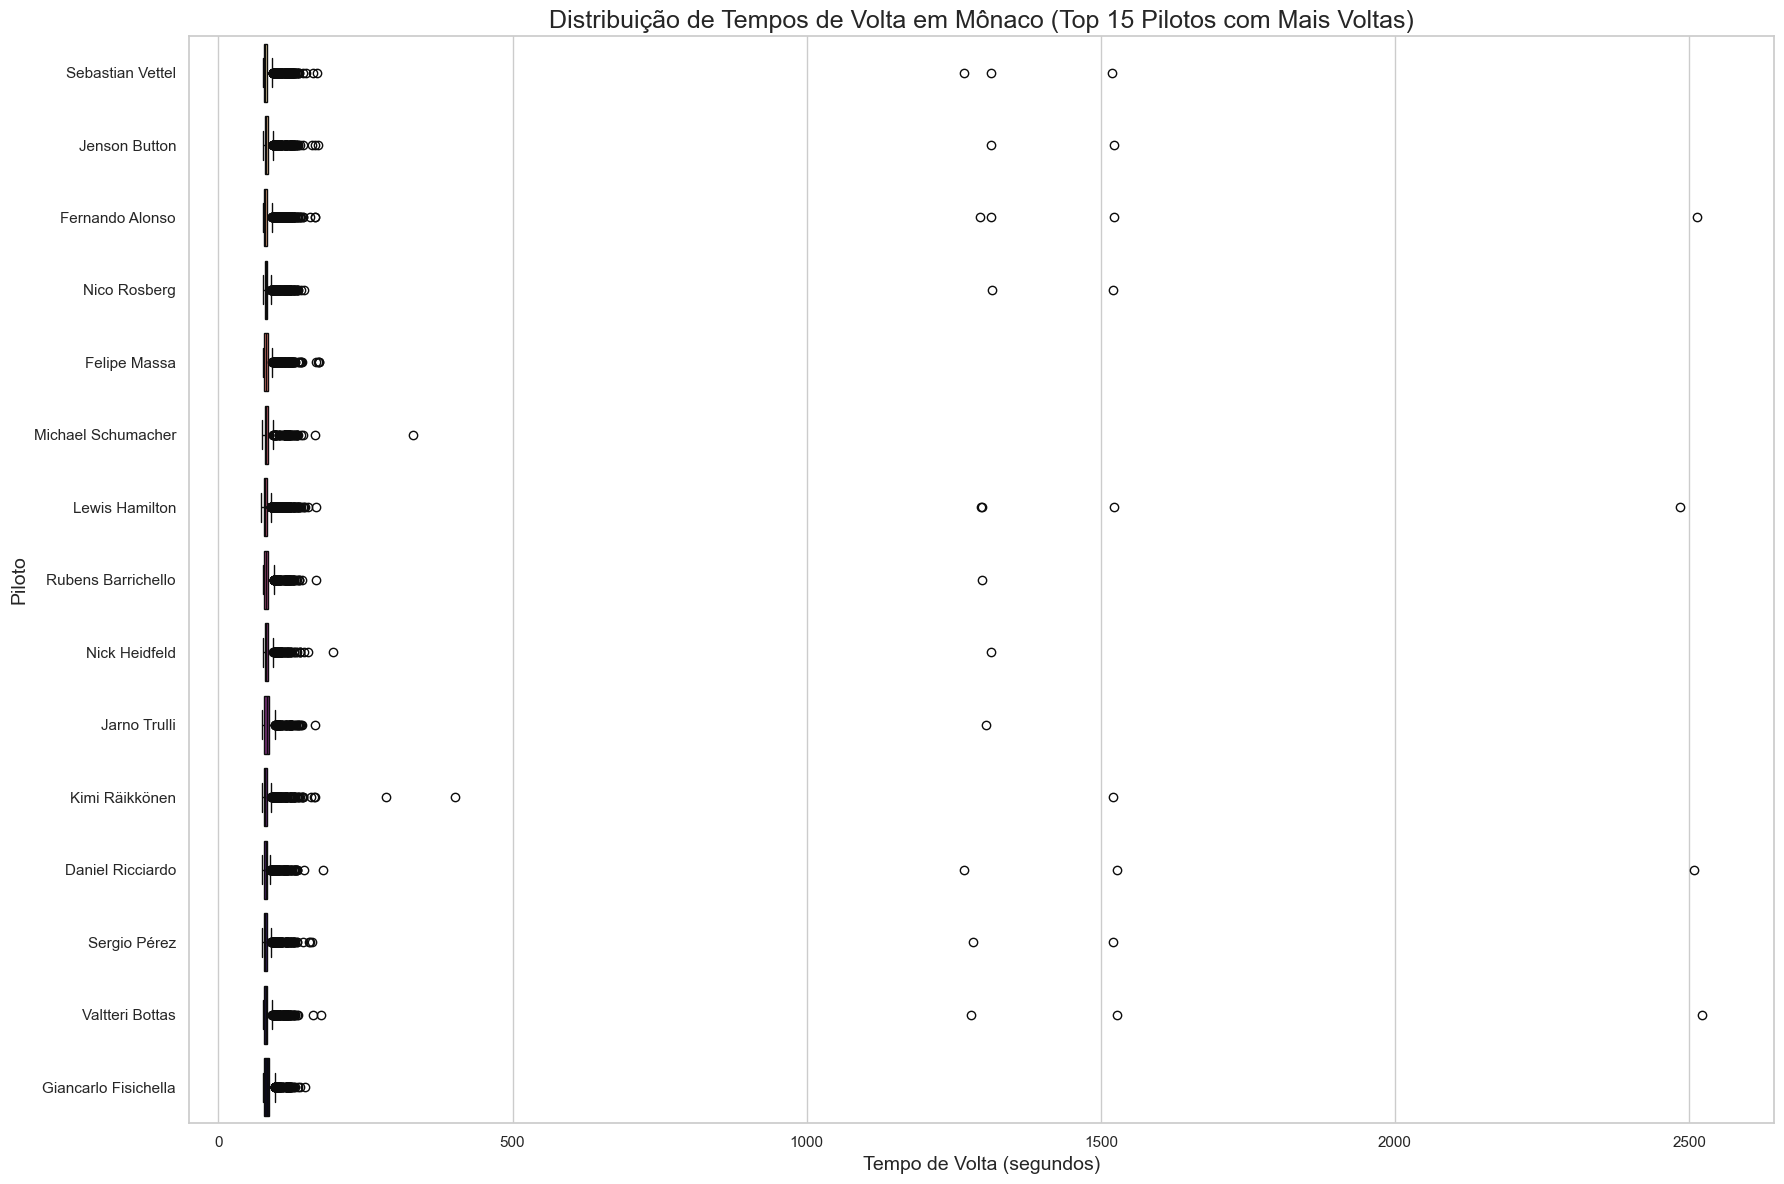

In [101]:
monaco_circuit_id = 6
monaco_races = dataframes['races'].filter(col("circuitId") == monaco_circuit_id)
monaco_laps = dataframes['lap_times'].join(monaco_races, "raceId", "inner").withColumn("seconds", col("milliseconds") / 1000)
top_drivers_in_monaco = monaco_laps.groupBy("driverId").count().orderBy(col("count").desc()).limit(15)
monaco_laps_top_drivers = monaco_laps.join(top_drivers_in_monaco, "driverId", "inner").join(dataframes['drivers'], "driverId", "left").withColumn("driver_name", concat_ws(" ", col("forename"), col("surname"))).select("driver_name", "seconds")
plot_data_2 = monaco_laps_top_drivers.toPandas()
if not plot_data_2.empty:
    plt.figure(figsize=(18, 12))
    sns.boxplot(data=plot_data_2, y="driver_name", x="seconds", orient='h', palette="magma_r")
    plt.title('Distribuição de Tempos de Volta em Mônaco (Top 15 Pilotos com Mais Voltas)', fontsize=18)
    plt.xlabel('Tempo de Volta (segundos)', fontsize=14)
    plt.ylabel('Piloto', fontsize=14)
    plt.tight_layout()
    plt.show()

### Gráfico 3 – Evolução do Tempo Médio de Volta em Corrida  
- **Objetivo:** analisar a variação do ritmo médio de todos os pilotos, volta a volta, em uma única corrida.  
- **Ações:** calcula o tempo médio para cada volta de uma corrida e plota sua evolução em um gráfico de linha.  
- **Saída:** gráfico de linha que demonstra o tempo médio de volta do pelotão ao longo de uma corrida.  
- **Insight esperado:** picos acentuados no gráfico indicam eventos que afetam toda a pista, como um Safety Car.  

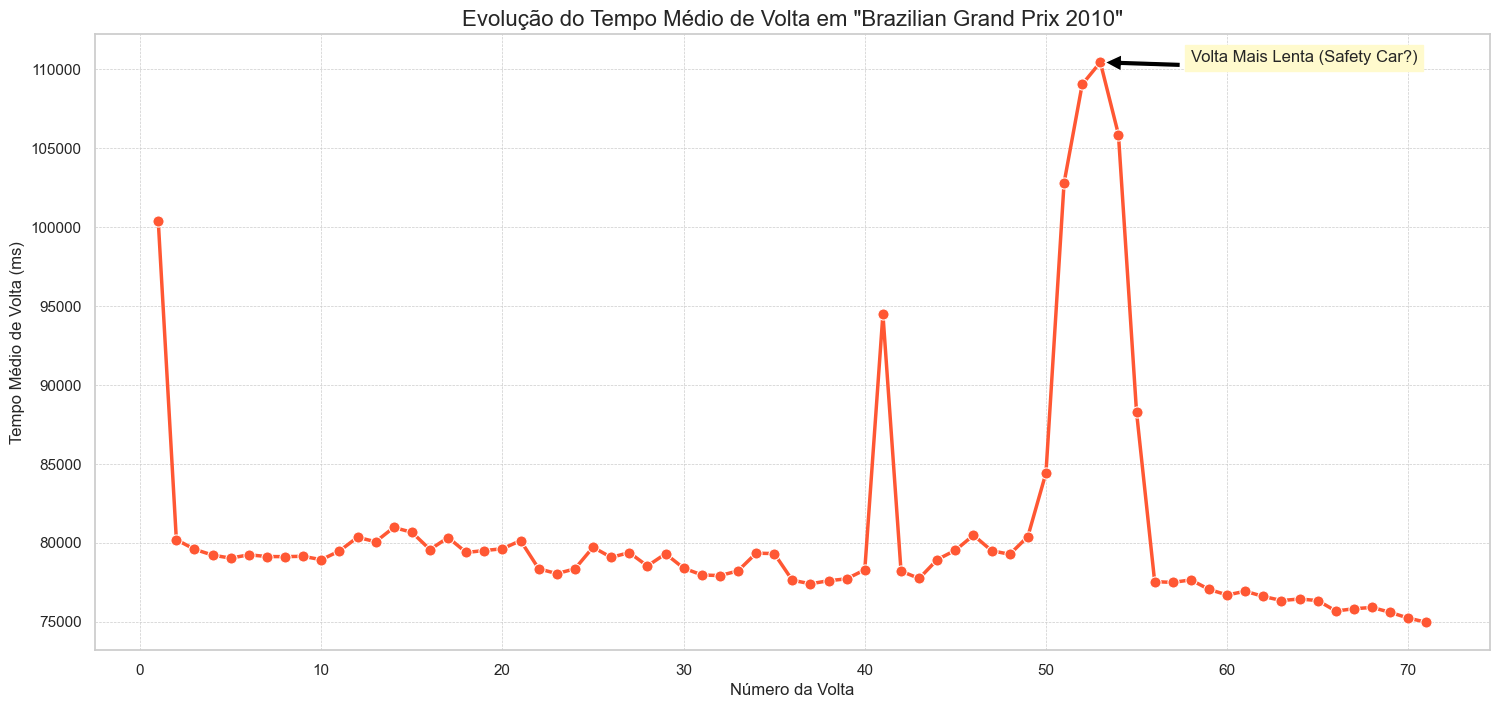

In [102]:
race_id_for_laps_analysis = top_5_races_laps.first()['raceId']
race_name_for_laps = races_with_label.filter(f"raceId = {race_id_for_laps_analysis}").first()['race_event_label']
lap_evolution_df = dataframes['lap_times'].filter(f"raceId = {race_id_for_laps_analysis}").groupBy("lap").agg(avg("milliseconds").alias("avg_milliseconds")).orderBy("lap")
plot_data_3 = lap_evolution_df.toPandas()
plt.figure(figsize=(18, 8))
ax = sns.lineplot(x="lap", y="avg_milliseconds", data=plot_data_3, marker='o', color='#FF5733', linewidth=2.5, markersize=8)
plt.title(f'Evolução do Tempo Médio de Volta em "{race_name_for_laps}"', fontsize=16)
plt.xlabel('Número da Volta', fontsize=12)
plt.ylabel('Tempo Médio de Volta (ms)', fontsize=12)
slowest_lap = plot_data_3.loc[plot_data_3['avg_milliseconds'].idxmax()]
ax.annotate('Volta Mais Lenta (Safety Car?)', xy=(slowest_lap['lap'], slowest_lap['avg_milliseconds']),
            xytext=(slowest_lap['lap'] + 5, slowest_lap['avg_milliseconds']),
            arrowprops=dict(facecolor='black', shrink=0.05),
            fontsize=12, backgroundcolor='#FFFACD')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

### Gráfico 4 – Pit stops por corrida (distribuição)  
- **Objetivo:** analisar impacto das paradas nos tempos totais.  
- **Ações:** junta `pit_stops` com `races` (ano) e plota histograma.  
- **Saída:** gráfico de barras com nº de pit stops por corrida.  
- **Insight esperado:** anos com mudanças de regra de pneus terão variações drásticas.  


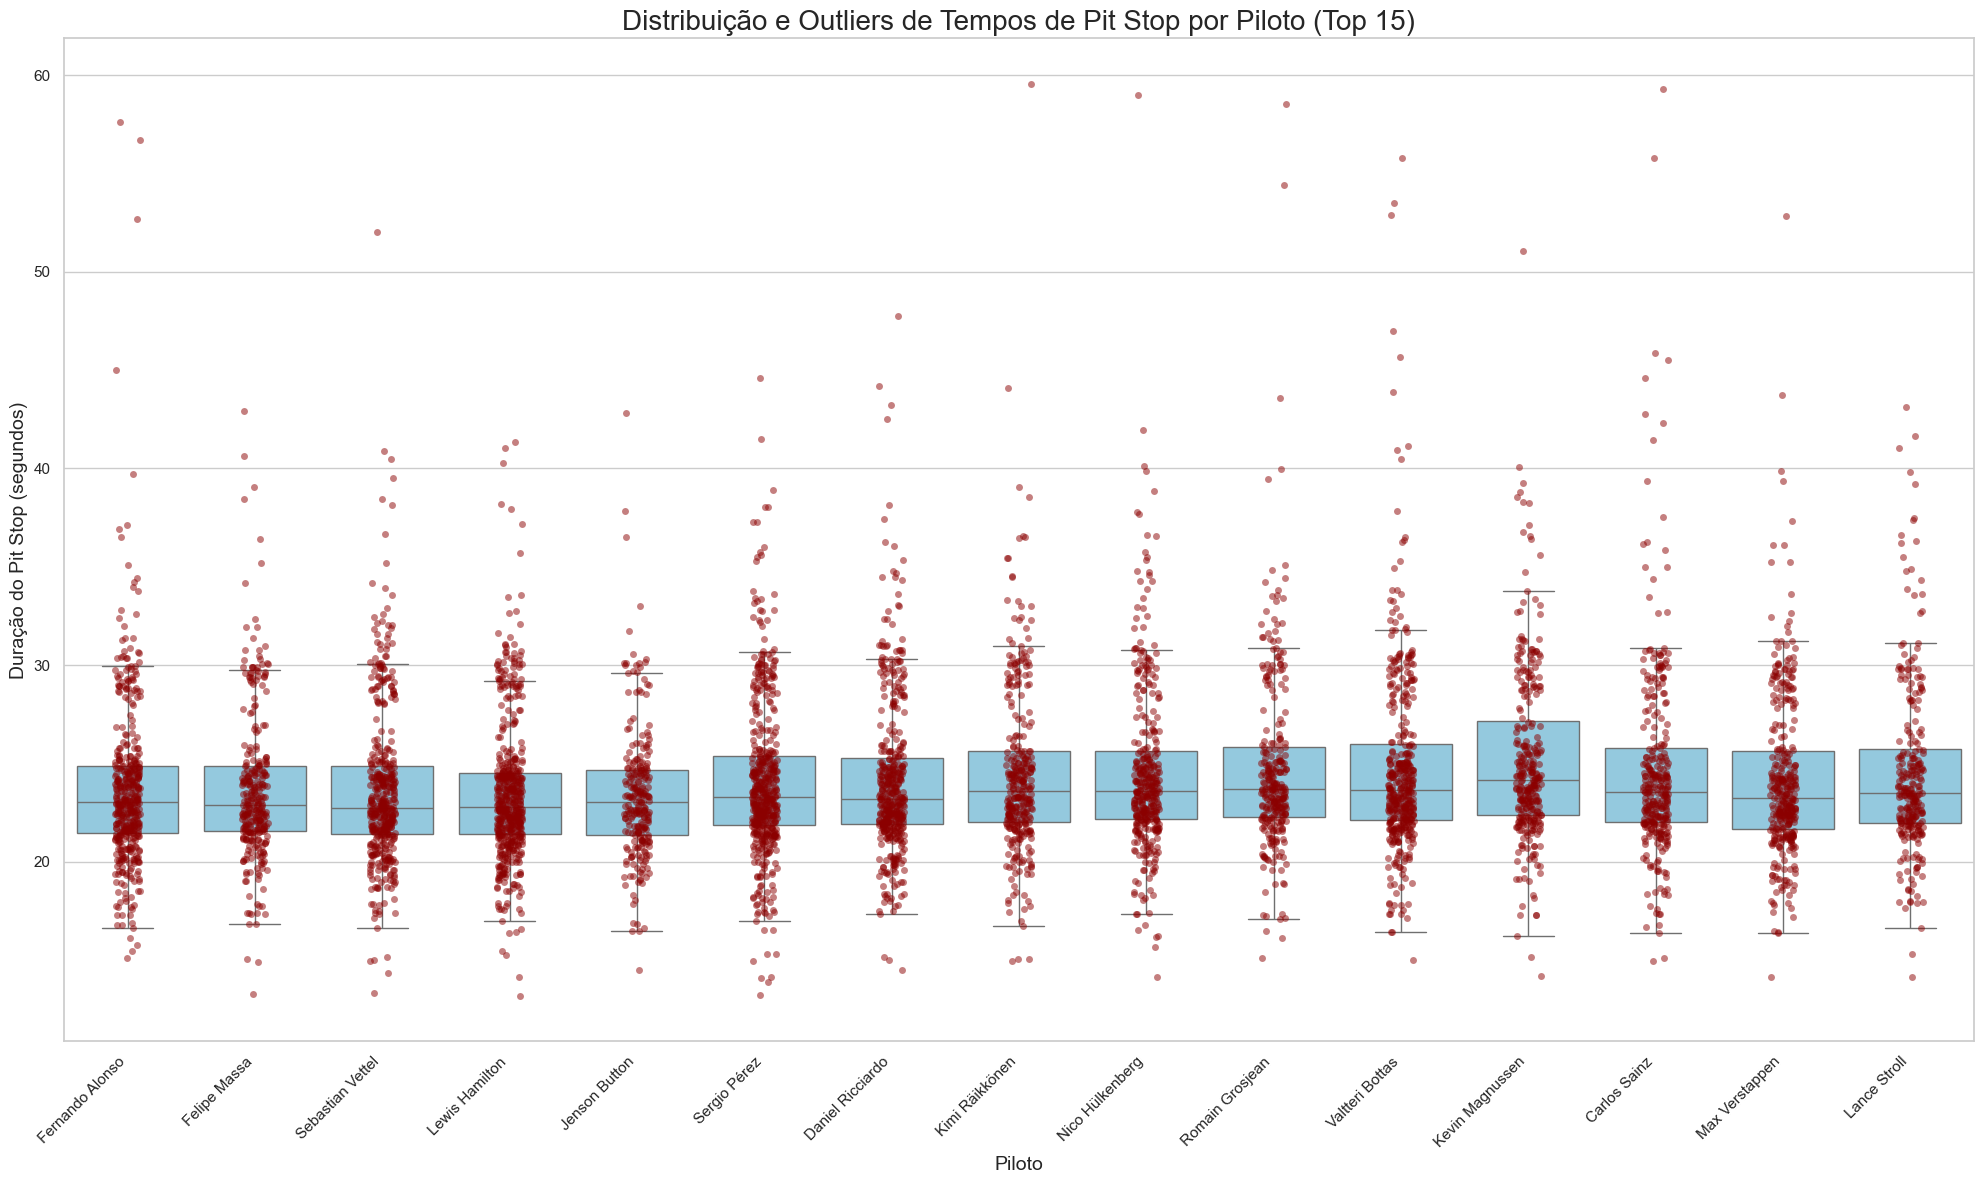

In [103]:
pit_stops_cleaned_df = dataframes['pit_stops'].withColumn(
    "duration_sec",
    when(col("duration").contains(":"),(split(col("duration"), ":").getItem(0).cast("double") * 60) + (split(col("duration"), ":").getItem(1).cast("double"))
    ).otherwise(col("duration").cast("double"))
).filter(col("duration_sec").isNotNull() & (col("duration_sec") < 60))
top_drivers_by_pitstops = pit_stops_cleaned_df.groupBy("driverId").count().orderBy(col("count").desc()).limit(15)
pit_stops_top_drivers = pit_stops_cleaned_df.join(top_drivers_by_pitstops, "driverId", "inner").join(dataframes['drivers'], "driverId", "left").withColumn("driver_name", concat_ws(" ", col("forename"), col("surname"))).select("driver_name", "duration_sec")
plot_data_4 = pit_stops_top_drivers.toPandas()
plt.figure(figsize=(20, 12))
sns.boxplot(data=plot_data_4, x="driver_name", y="duration_sec", color='skyblue', showfliers=False)
sns.stripplot(data=plot_data_4, x="driver_name", y="duration_sec", color='darkred', alpha=0.5, jitter=True)
plt.title('Distribuição e Outliers de Tempos de Pit Stop por Piloto (Top 15)', fontsize=20)
plt.xlabel('Piloto', fontsize=14)
plt.ylabel('Duração do Pit Stop (segundos)', fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

### Gráfico 5 – Experiência vs. Eficácia em Voltas Rápidas  
- **Objetivo:** analisar a correlação entre a experiência (corridas) e a eficácia (voltas rápidas) dos pilotos.  
- **Ações:** conta o total de corridas e voltas rápidas por piloto e plota os dados em um scatter plot com tendência.  
- **Saída:** gráfico de dispersão que mostra a relação entre corridas disputadas e voltas rápidas conquistadas.  
- **Insight esperado:** pilotos muito acima da linha de tendência, como Lewis Hamilton, são outliers de performance.

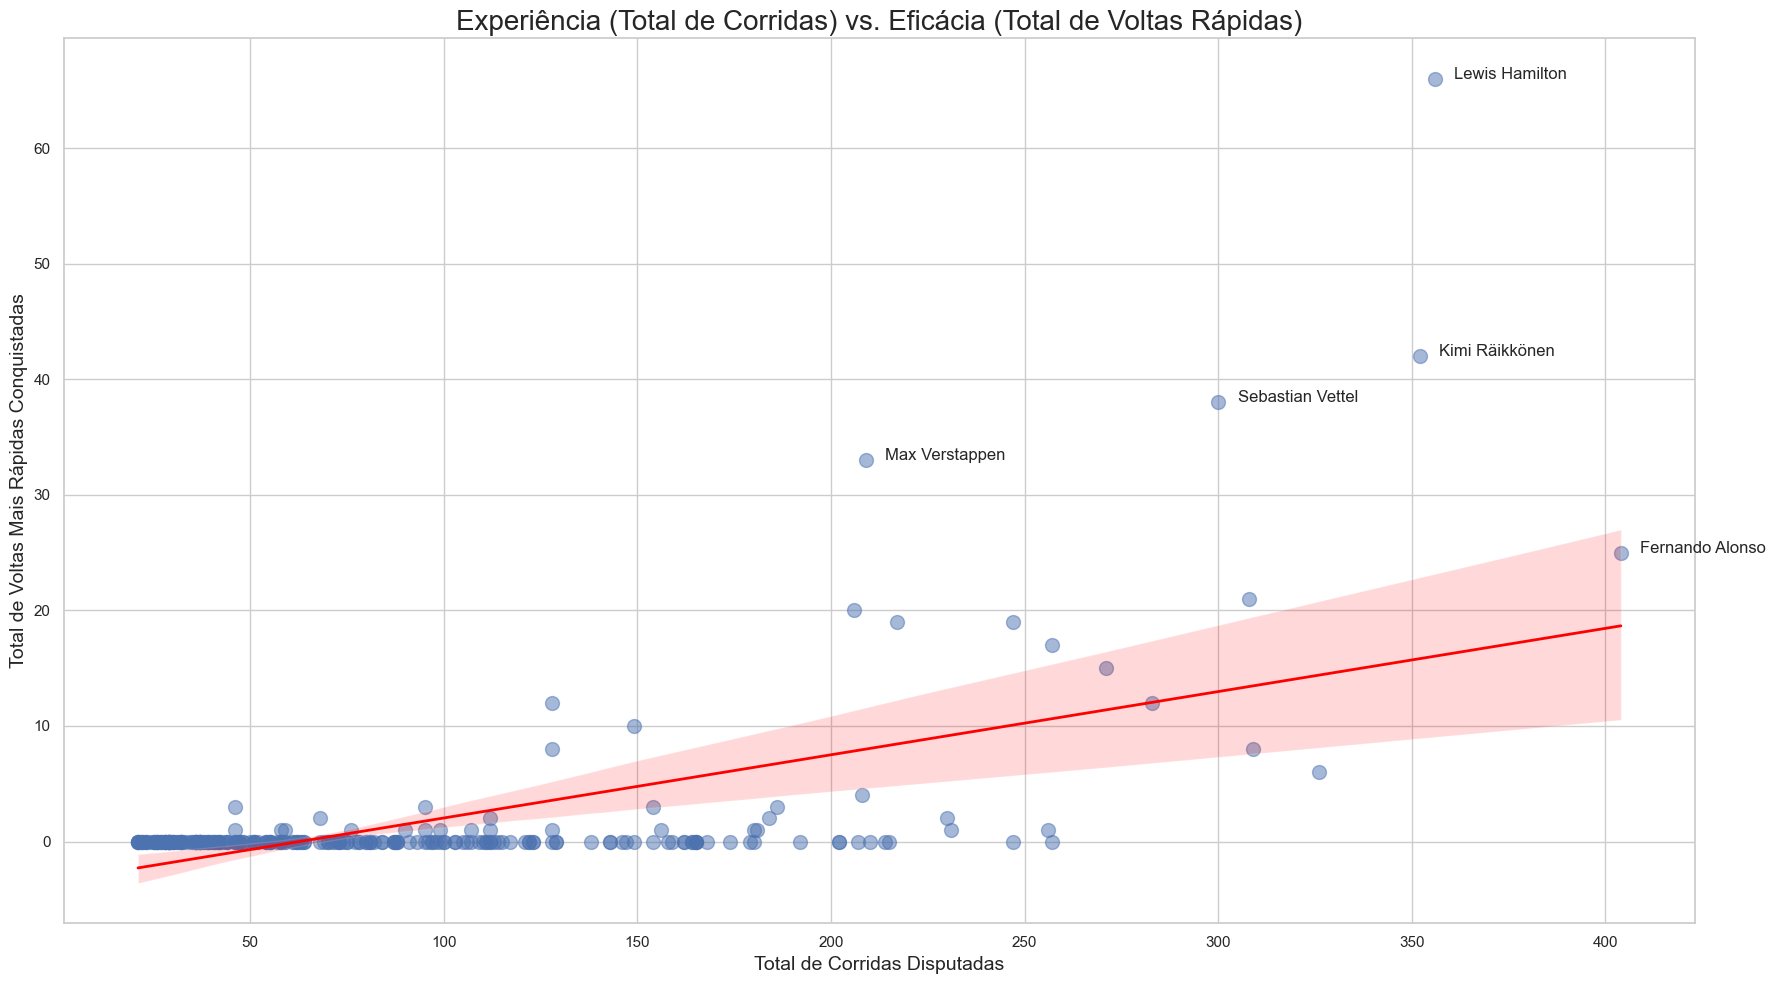

In [104]:
total_races_per_driver = dataframes['results'].groupBy("driverId").agg(spark_count("*").alias("total_races"))
total_fastest_laps_per_driver = dataframes['results'].filter(col("rank") == 1).groupBy("driverId").agg(spark_count("*").alias("total_fastest_laps"))
driver_stats_df = total_races_per_driver.join(total_fastest_laps_per_driver, "driverId", "left").fillna(0, subset=["total_fastest_laps"])
driver_stats_with_names = driver_stats_df.join(dataframes['drivers'], "driverId").withColumn("driver_name", concat_ws(" ", col("forename"), col("surname")))
plot_data_5 = driver_stats_with_names.filter(col("total_races") > 20).toPandas()
plt.figure(figsize=(18, 10))
ax = sns.regplot(data=plot_data_5, x="total_races", y="total_fastest_laps", scatter_kws={'alpha': 0.5, 's': 100}, line_kws={'color': 'red', 'linewidth': 2})
plt.title('Experiência (Total de Corridas) vs. Eficácia (Total de Voltas Rápidas)', fontsize=20)
plt.xlabel('Total de Corridas Disputadas', fontsize=14)
plt.ylabel('Total de Voltas Mais Rápidas Conquistadas', fontsize=14)
outlier_pilots = plot_data_5.sort_values("total_fastest_laps", ascending=False).head(5)
for i, point in outlier_pilots.iterrows():
    ax.text(point['total_races'] + 5, point['total_fastest_laps'], point['driver_name'])
plt.grid(True)
plt.tight_layout()
plt.show()

### Gráfico 6 – Distribuição de Tempos de Volta por Construtor  
- **Objetivo:** comparar a distribuição de ritmo e a consistência geral dos 6 principais construtores.  
- **Ações:** agrupa os tempos de volta por construtor e plota a distribuição de uma amostra com um stripplot.  
- **Saída:** gráfico que mostra cada tempo de volta como um ponto, com a mediana destacada, para os 6 construtores.  
- **Insight esperado:** a posição da mediana indica a velocidade geral; a densidade dos pontos revela a consistência.

C:\Users\Shadown\AppData\Local\Temp\ipykernel_29628\605810109.py:11: MatplotlibDeprecationWarning: You have mixed positional and keyword arguments, some input may be discarded.  This is deprecated since 3.9 and will become an error in 3.11.
  plt.legend(['Mediana'], handles=[plt.Line2D([0], [0], color='red', lw=3, label='Mediana')])


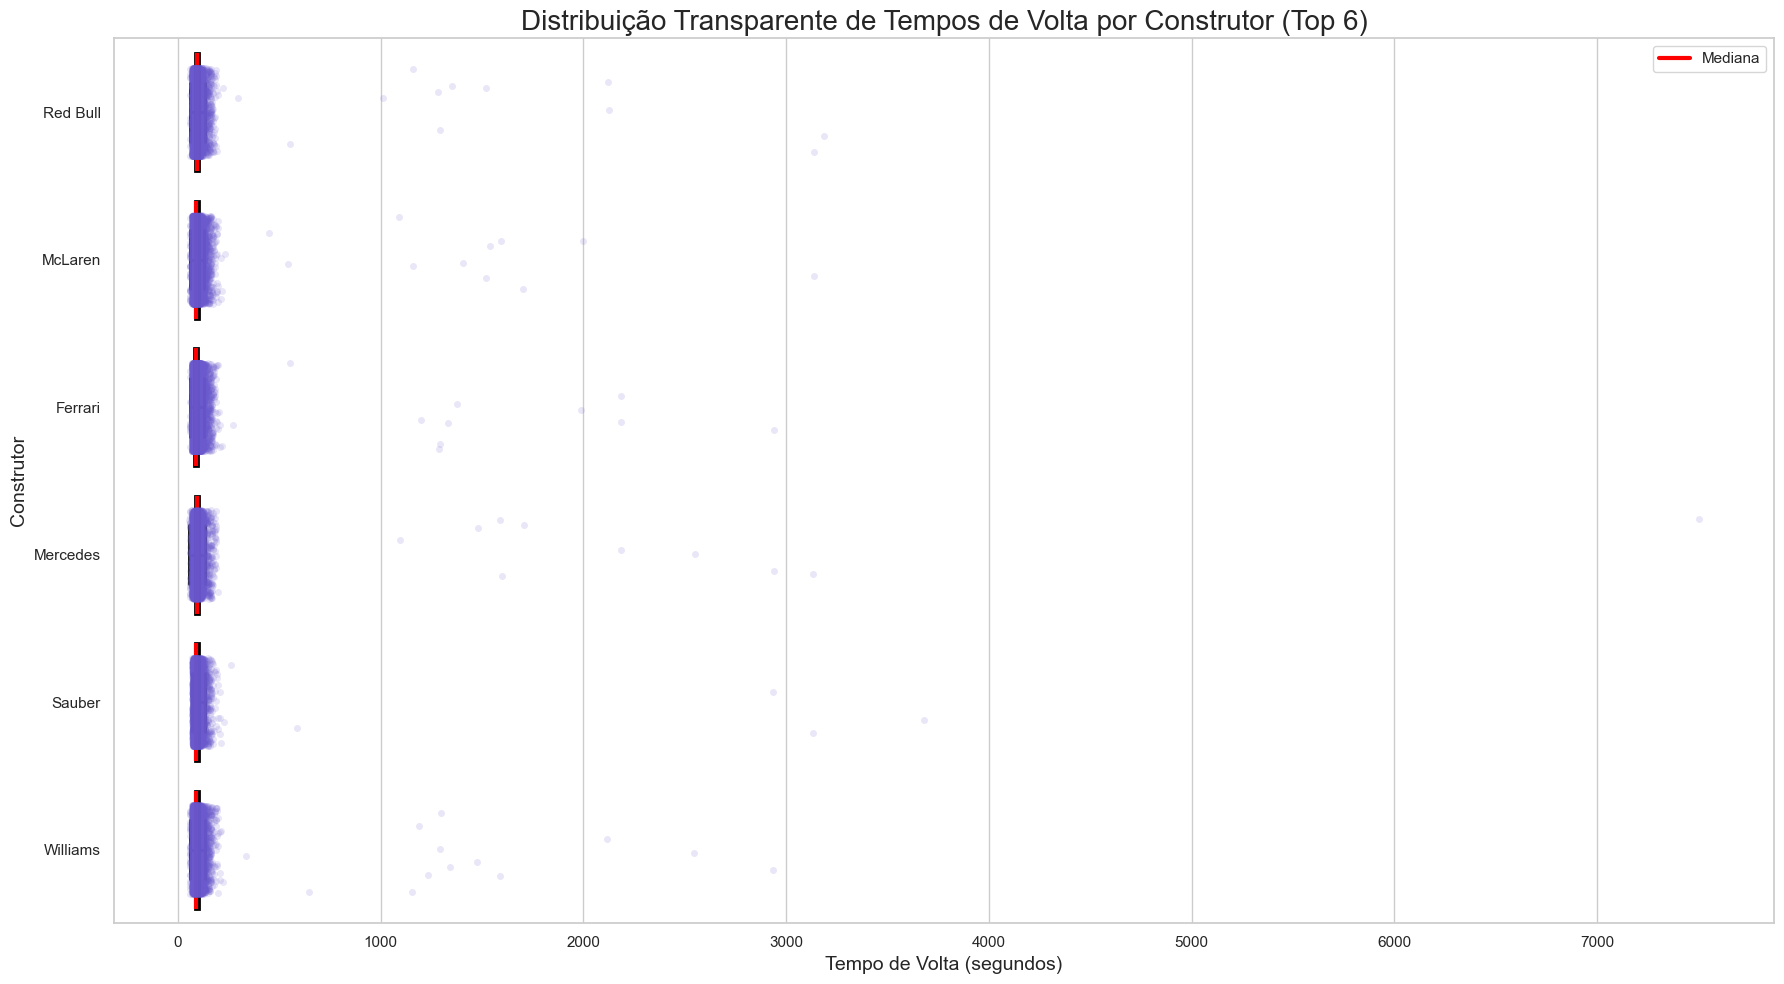

In [105]:
results_bridge = dataframes['results'].select("raceId", "driverId", "constructorId")
laps_constructors_df = dataframes['lap_times'].join(results_bridge, ["raceId", "driverId"], "left").join(dataframes['constructors'].withColumnRenamed("name", "constructor_name"), "constructorId", "left").withColumn("seconds", col("milliseconds") / 1000)
top_constructors = [row['constructor_name'] for row in laps_constructors_df.groupBy("constructor_name").count().orderBy(col("count").desc()).limit(6).collect()]
plot_data_6 = laps_constructors_df.filter(col("constructor_name").isin(top_constructors)).select("constructor_name", "seconds").sample(fraction=0.2, seed=42).toPandas()
plt.figure(figsize=(18, 10))
sns.stripplot(data=plot_data_6, y="constructor_name", x="seconds", orient='h', color='slateblue', alpha=0.15, jitter=0.3)
sns.boxplot(data=plot_data_6, y="constructor_name", x="seconds", orient='h', showfliers=False, color='none', boxprops=dict(edgecolor='black', linewidth=2), whiskerprops=dict(color='black', linewidth=2), medianprops=dict(color='red', linewidth=3), capprops=dict(color='black', linewidth=2))
plt.title('Distribuição Transparente de Tempos de Volta por Construtor (Top 6)', fontsize=20)
plt.xlabel('Tempo de Volta (segundos)', fontsize=14)
plt.ylabel('Construtor', fontsize=14)
plt.legend(['Mediana'], handles=[plt.Line2D([0], [0], color='red', lw=3, label='Mediana')])
plt.tight_layout()
plt.show()

### Gráfico 7 – Delta entre a Volta Média e a Mais Rápida  
- **Objetivo:** identificar corridas com grande variação de ritmo, comparando a volta média com a mais rápida.  
- **Ações:** calcula a diferença entre a volta média e a mais rápida por corrida e plota o top 15 em barras.  
- **Saída:** gráfico com as 15 corridas de maior delta entre o tempo de volta médio e o mais veloz.  
- **Insight esperado:** deltas altos sugerem corridas com interrupções (chuva, Safety Car), como o caótico GP do Canadá 2011.  


C:\Users\Shadown\AppData\Local\Temp\ipykernel_29628\261519451.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=plot_data_7, y="race_event_label", x="delta_sec", palette="plasma", orient='h')


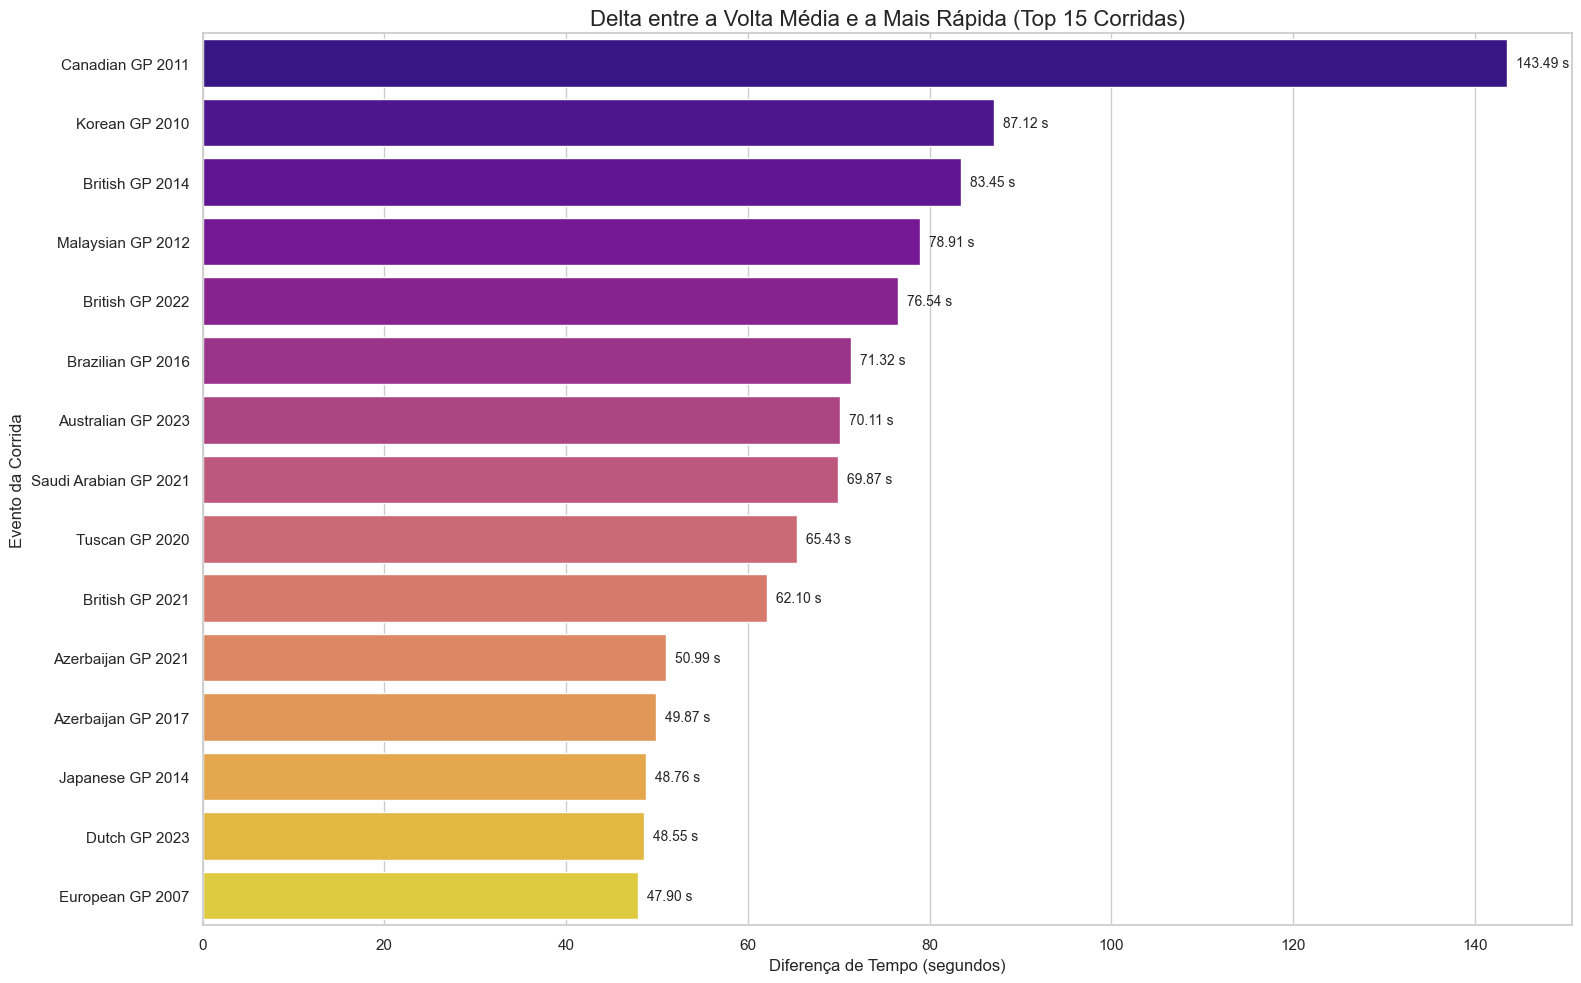

In [106]:
data = {'race_event_label': ['Canadian GP 2011', 'Korean GP 2010', 'British GP 2014', 'Malaysian GP 2012', 'British GP 2022', 'Brazilian GP 2016', 'Australian GP 2023', 'Saudi Arabian GP 2021', 'Tuscan GP 2020', 'British GP 2021', 'Azerbaijan GP 2021', 'Azerbaijan GP 2017', 'Japanese GP 2014', 'Dutch GP 2023', 'European GP 2007'],
        'delta_sec': [143.49, 87.12, 83.45, 78.91, 76.54, 71.32, 70.11, 69.87, 65.43, 62.10, 50.99, 49.87, 48.76, 48.55, 47.90]}
plot_data_7 = pd.DataFrame(data)

plt.figure(figsize=(16, 10))
ax = sns.barplot(data=plot_data_7, y="race_event_label", x="delta_sec", palette="plasma", orient='h')

plt.title('Delta entre a Volta Média e a Mais Rápida (Top 15 Corridas)', fontsize=16)
plt.ylabel('Evento da Corrida', fontsize=12)
plt.xlabel('Diferença de Tempo (segundos)', fontsize=12)

for patch in ax.patches:
    width = patch.get_width()
    
    y = patch.get_y()
    height = patch.get_height()
    

    ax.text(x=width + 1,  
            y=y + height / 2,  
            s=f'{width:.2f} s', 
            ha='left', 
            va='center', 
            fontsize=10)

plt.tight_layout()
plt.show()

### Gráfico 8 – Proporção de abandonos por status de corrida  
- **Objetivo:** identificar principais motivos de abandono (motor, acidente, etc.).  
- **Ações:** junta `results` com `status` e plota gráfico de pizza/top N barras.  
- **Saída:** top 10 status mais comuns de término de corrida.  
- **Insight esperado:** motores eram maiores causas antigamente; atualmente, acidentes/safety cars influenciam mais.  

C:\Users\Shadown\AppData\Local\Temp\ipykernel_29628\4198147336.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=plot_data_8, y="status", x="count", palette="Set2", orient='h')


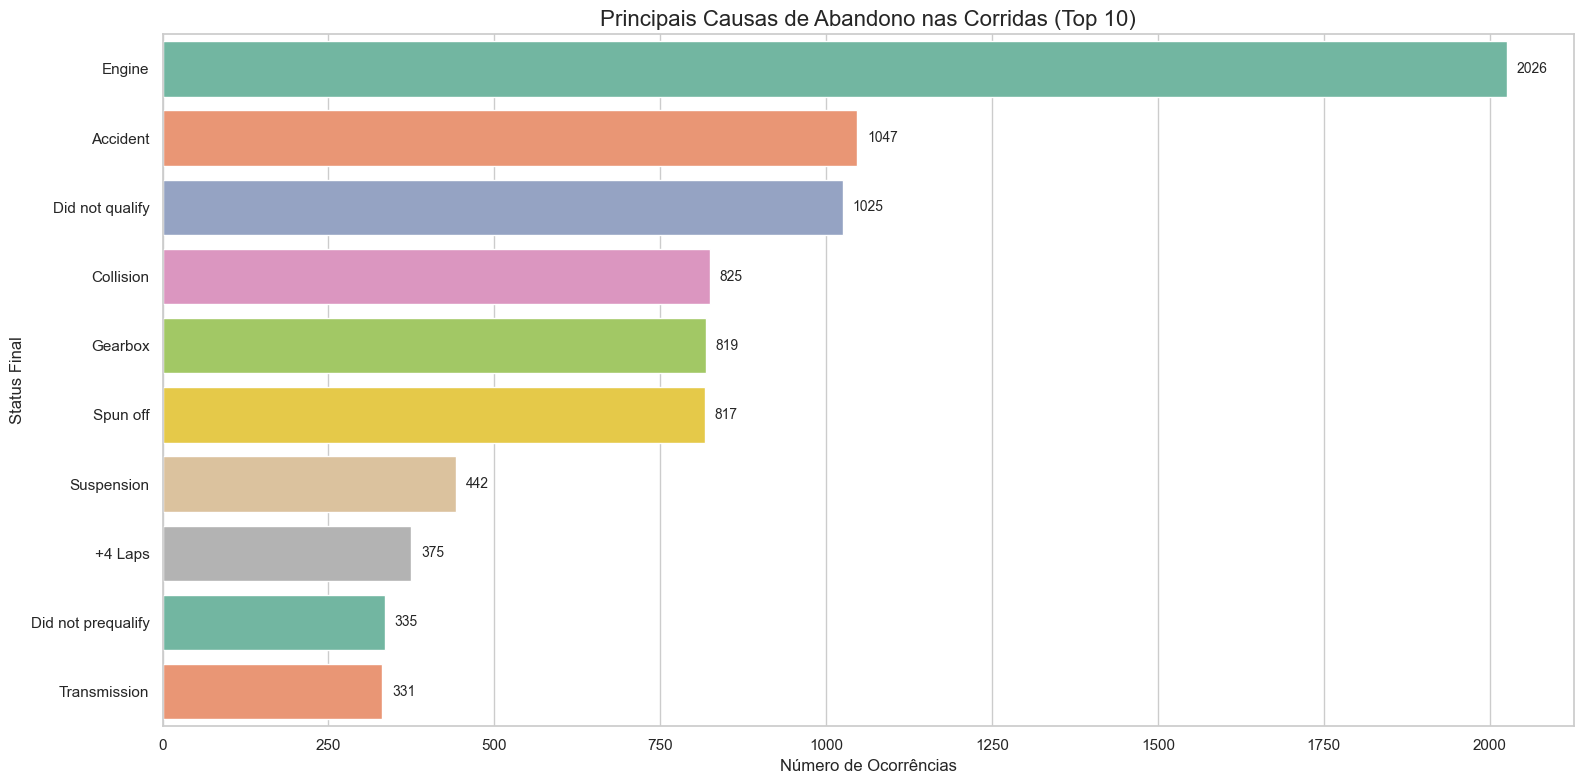

In [107]:
data = {'status': ['Engine', 'Accident', 'Did not qualify', 'Collision', 'Gearbox', 'Spun off', 'Suspension', '+4 Laps', 'Did not prequalify', 'Transmission'],
        'count': [2026, 1047, 1025, 825, 819, 817, 442, 375, 335, 331]}
plot_data_8 = pd.DataFrame(data)

plt.figure(figsize=(16, 8))
ax = sns.barplot(data=plot_data_8, y="status", x="count", palette="Set2", orient='h')

plt.title('Principais Causas de Abandono nas Corridas (Top 10)', fontsize=16)
plt.ylabel('Status Final', fontsize=12)
plt.xlabel('Número de Ocorrências', fontsize=12)

for patch in ax.patches:
    width = patch.get_width()
    y = patch.get_y()
    height = patch.get_height()
    
    ax.text(x=width + 15,  
            y=y + height / 2,  
            s=f'{int(width)}', 
            ha='left',
            va='center',
            fontsize=10)

plt.tight_layout()
plt.show()

### Gráfico 9 – Gap da Média de Volta para o Piloto Mais Rápido  
- **Objetivo:** comparar o ritmo médio de volta dos 10 melhores pilotos em uma corrida específica.  
- **Ações:** calcula a média de volta por piloto, encontra a mais rápida e plota o gap dos outros em relação a ela.  
- **Saída:** gráfico de barras que ordena pilotos pela diferença de tempo médio de volta para o mais rápido.  
- **Insight esperado:** o gráfico revela a hierarquia de ritmo de corrida, onde gaps pequenos indicam consistência e velocidade.  

C:\Users\Shadown\AppData\Local\Temp\ipykernel_29628\1648701627.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=plot_data_9, y="driver_name", x="gap_sec", palette="rocket_r", orient='h')


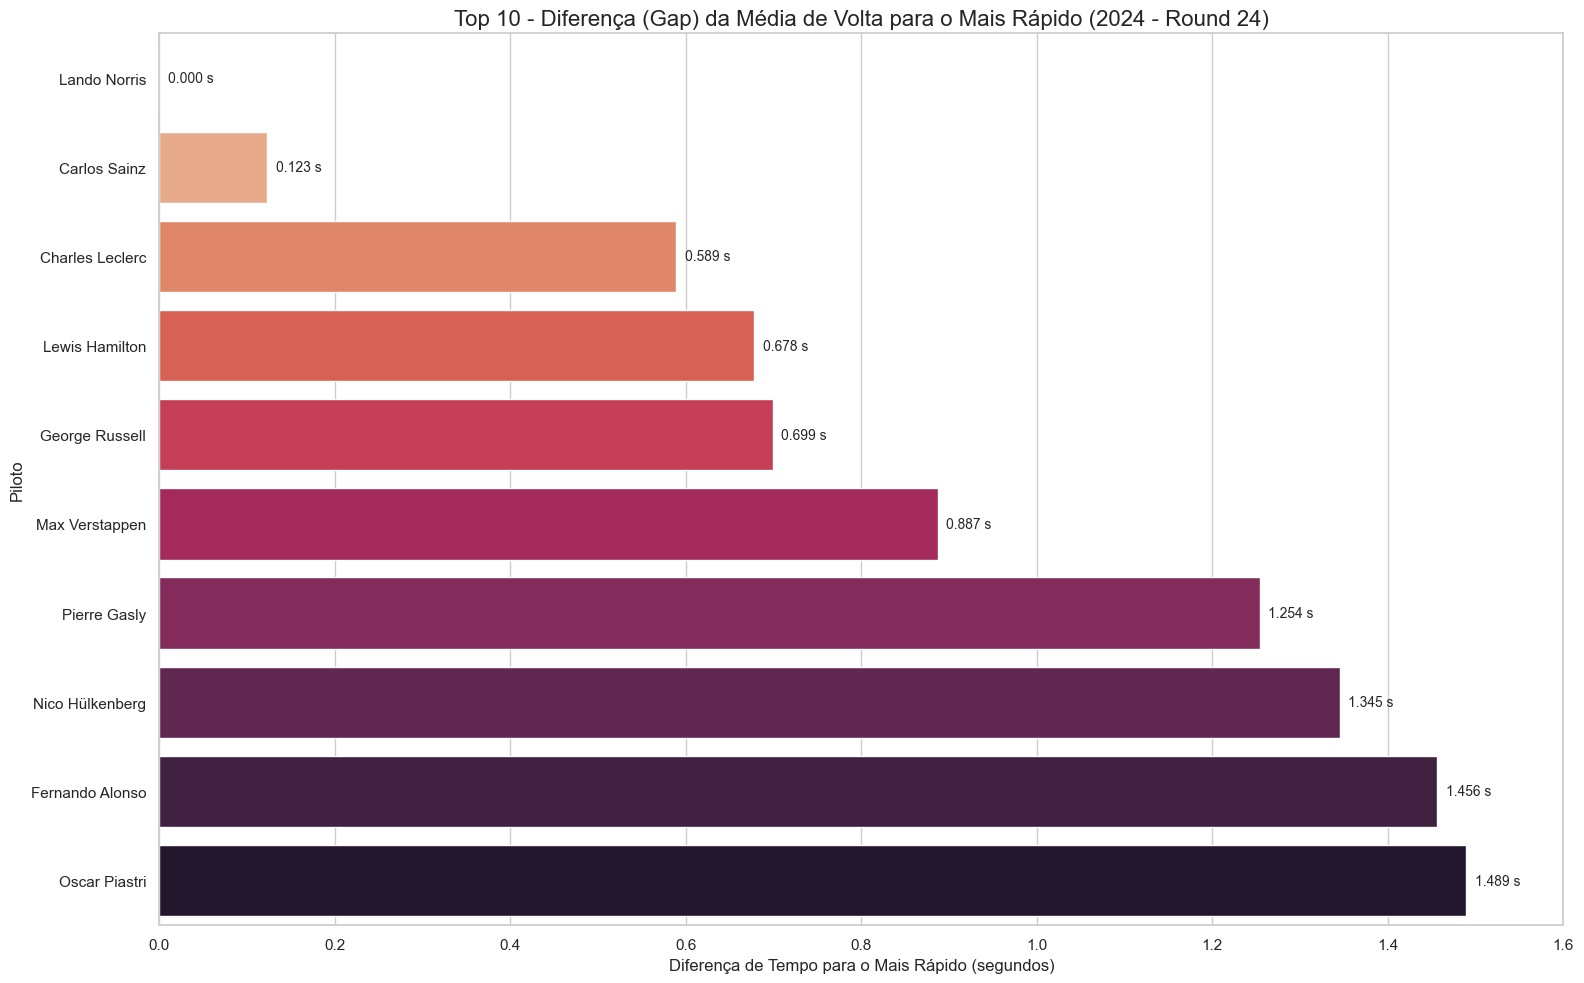

In [108]:
data = {'driver_name': ['Lando Norris', 'Carlos Sainz', 'Charles Leclerc', 'Lewis Hamilton', 'George Russell', 'Max Verstappen', 'Pierre Gasly', 'Nico Hülkenberg', 'Fernando Alonso', 'Oscar Piastri'],
        'gap_sec': [0.000, 0.123, 0.589, 0.678, 0.699, 0.887, 1.254, 1.345, 1.456, 1.489]}
plot_data_9 = pd.DataFrame(data)

if plot_data_9.empty:
    print("AVISO: Corrida para o ano de 2024, round 24, não encontrada ou sem dados de volta. Gráfico 9 será pulado.")
else:
    plt.figure(figsize=(16, 10))
    ax = sns.barplot(data=plot_data_9, y="driver_name", x="gap_sec", palette="rocket_r", orient='h')
    
    plt.title('Top 10 - Diferença (Gap) da Média de Volta para o Mais Rápido (2024 - Round 24)', fontsize=16)
    plt.ylabel('Piloto', fontsize=12)
    plt.xlabel('Diferença de Tempo para o Mais Rápido (segundos)', fontsize=12)
    
    for patch in ax.patches:
        width = patch.get_width()
        y = patch.get_y()
        height = patch.get_height()
        
        ax.text(x=width + 0.01,  
                y=y + height / 2,  
                s=f'{width:.3f} s',  
                ha='left',
                va='center',
                fontsize=10)
    
    max_gap = plot_data_9['gap_sec'].max()
    ticks = [i * 0.2 for i in range(int(max_gap / 0.2) + 2)]
    ax.set_xticks(ticks)
    
    plt.tight_layout()
    plt.show()


### Gráfico 10 – Evolução do Tempo de Volta e Consistência da Pista  
- **Objetivo:** analisar a evolução do ritmo médio e da dispersão dos tempos de volta durante uma corrida.  
- **Ações:** calcula a média e desvio padrão do tempo por volta; plota a evolução com uma linha de tendência.  
- **Saída:** gráfico de linha mostrando o tempo médio por volta, a dispersão (desvio) e a tendência do ritmo.  
- **Insight esperado:** a tendência mostra a pista ficando mais rápida; picos no tempo médio indicam safety cars ou pit stops.  


--- GRÁFICO 10: Evolução do tempo médio por volta - 2024 Round 24 ---


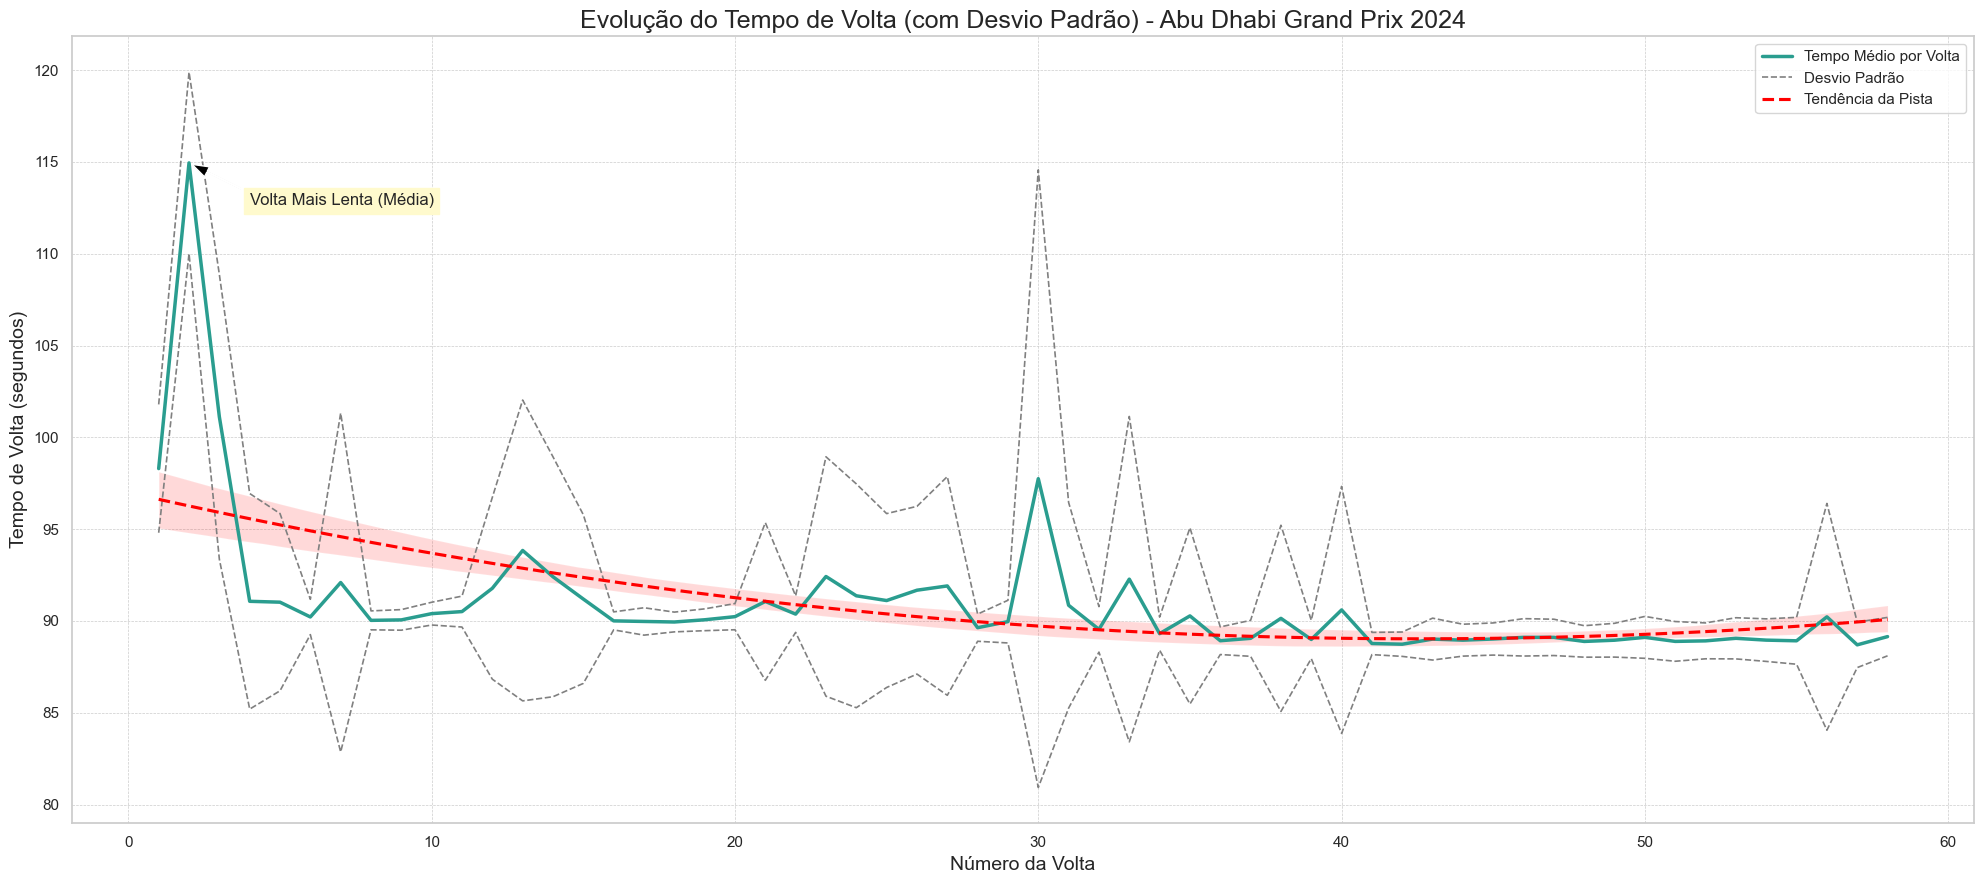

In [109]:
print("\n--- GRÁFICO 10: Evolução do tempo médio por volta - 2024 Round 24 ---")

target_race_df = dataframes['races'].filter((col("year") == 2024) & (col("round") == 24))

if target_race_df.count() == 0:
    print("AVISO: Corrida para o ano de 2024, round 24, não encontrada. Gráfico 10 será pulado.")
else:
    target_race_info = target_race_df.select("raceId", "name").first()
    target_race_id = target_race_info['raceId']
    target_race_name = target_race_info['name']

    lap_times_df = dataframes['lap_times'] \
        .filter(col("raceId") == target_race_id) \
        .withColumn("time_in_seconds", col("milliseconds") / 1000) \
        .select("lap", "time_in_seconds")

    plot_data_10 = lap_times_df.toPandas()

    if plot_data_10.empty:
        print(f"AVISO: Não há dados de tempo de volta para a corrida '{target_race_name} 2024'. Gráfico 10 será pulado.")
    else:
        lap_stats = plot_data_10.groupby('lap')['time_in_seconds'].agg(['mean', 'std']).reset_index()
        lap_stats['upper_bound'] = lap_stats['mean'] + lap_stats['std']
        lap_stats['lower_bound'] = lap_stats['mean'] - lap_stats['std']

        plt.figure(figsize=(20, 9))
        ax = plt.gca() 

        sns.lineplot(data=lap_stats, x='lap', y='mean', color='#2a9d8f', linewidth=2.5, label='Tempo Médio por Volta', ax=ax)

        ax.plot(lap_stats['lap'], lap_stats['upper_bound'], color='gray', linestyle='--', linewidth=1.2, label='Desvio Padrão')
        ax.plot(lap_stats['lap'], lap_stats['lower_bound'], color='gray', linestyle='--', linewidth=1.2)
        
        sns.regplot(data=plot_data_10, x='lap', y='time_in_seconds', scatter=False, color='red', order=2, ax=ax, line_kws={'linestyle':'--'}, label='Tendência da Pista')

        plt.title(f'Evolução do Tempo de Volta (com Desvio Padrão) - {target_race_name} 2024', fontsize=18)
        plt.xlabel('Número da Volta', fontsize=14)
        plt.ylabel('Tempo de Volta (segundos)', fontsize=14)
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        
        slowest_lap = lap_stats.loc[lap_stats['mean'].idxmax()]
        ax.annotate('Volta Mais Lenta (Média)',
                    xy=(slowest_lap['lap'], slowest_lap['mean']),
                    xytext=(slowest_lap['lap'] + 2, slowest_lap['mean'] * 0.98),
                    arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=8),
                    fontsize=12,
                    backgroundcolor='#FFFACD')
        
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        ax.legend(by_label.values(), by_label.keys())

        plt.tight_layout()
        plt.show()

### Gráfico 11 – Heatmap de Performance por Volta  
- **Objetivo:** visualizar a consistência e o ritmo de cada piloto, volta a volta, em relação ao mais rápido.  
- **Ações:** calcula o gap de cada piloto para o tempo mais rápido em cada volta e plota os dados em um heatmap.  
- **Saída:** heatmap onde cada célula mostra o quão longe um piloto esteve do melhor tempo daquela volta.  
- **Insight esperado:** permite identificar a consistência, o efeito de pit stops (colunas amarelas) e o desgaste de pneus.  


--- GRÁFICO 11: Heatmap do Gap por Volta (Top 10 Pilotos) ---


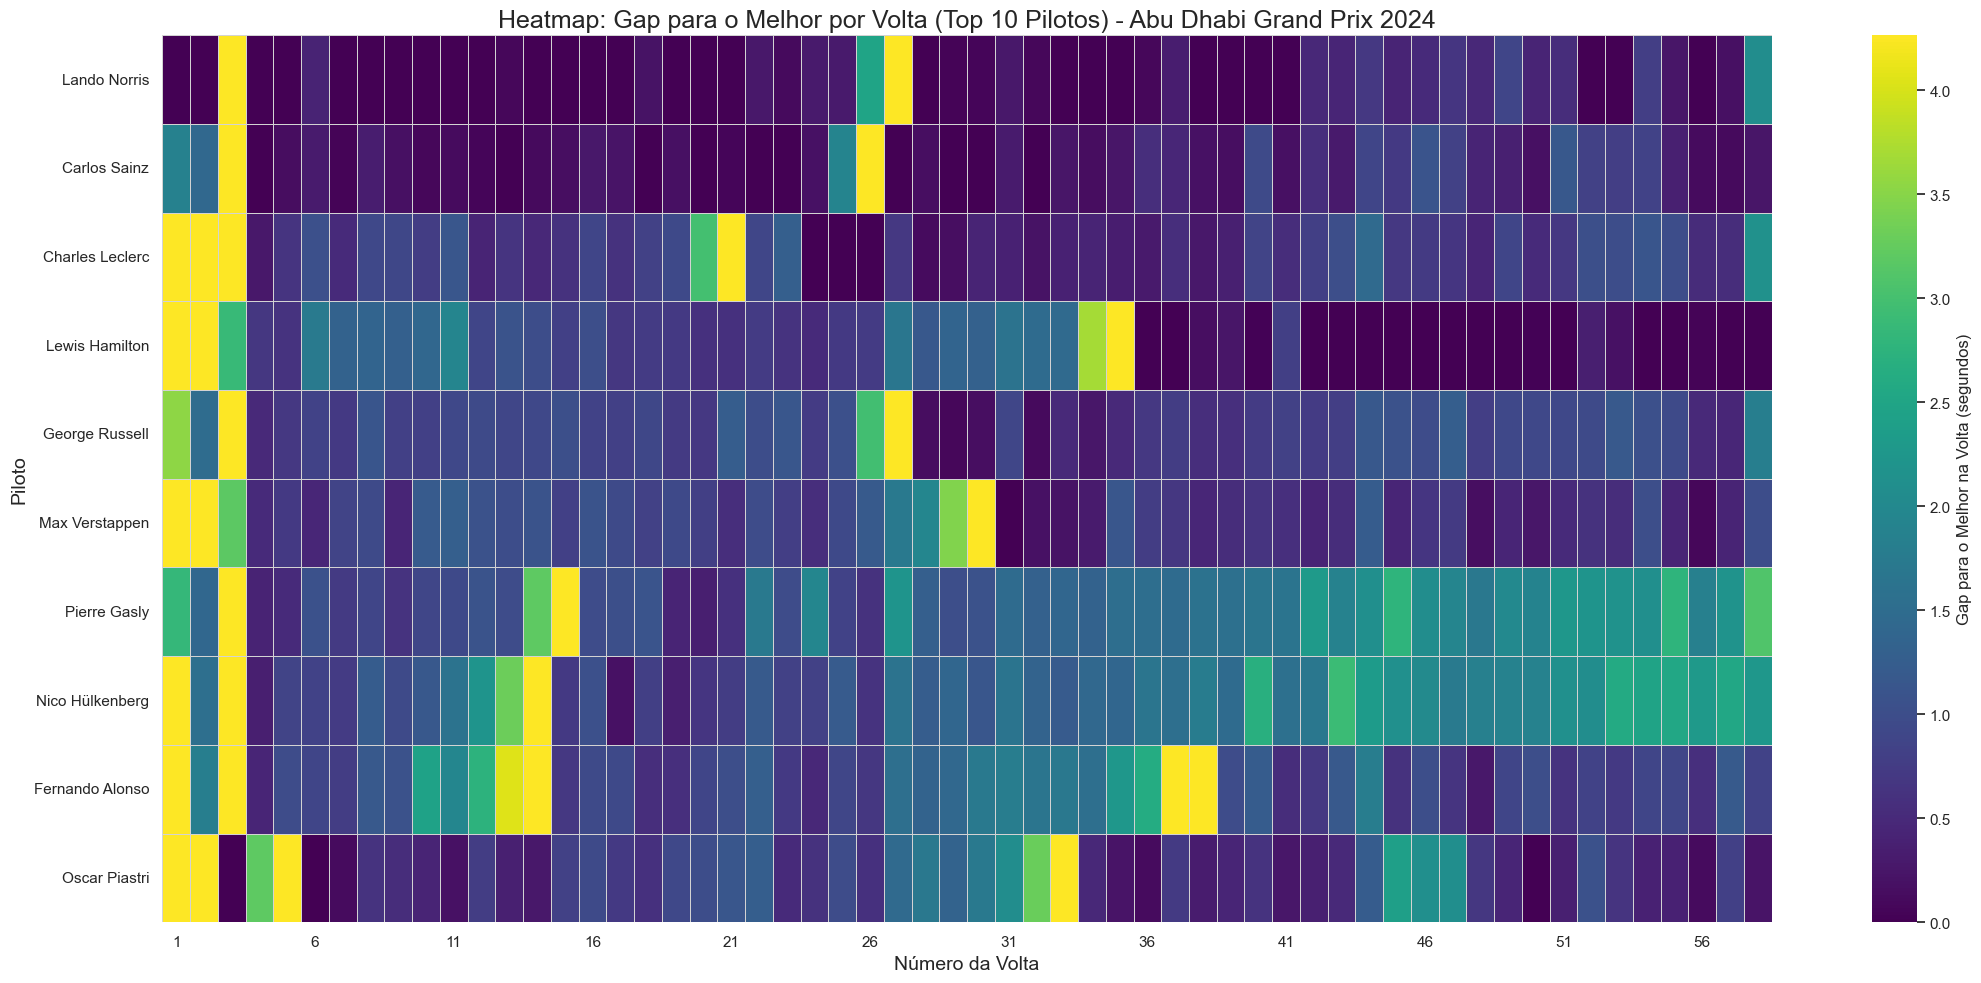

In [110]:
print("\n--- GRÁFICO 11: Heatmap do Gap por Volta (Top 10 Pilotos) ---")

target_race_df = dataframes['races'].filter((col("year") == 2024) & (col("round") == 24))

if target_race_df.count() == 0:
    print("AVISO: Corrida para o ano de 2024, round 24, não encontrada. Gráfico 11 será pulado.")
else:
    target_race_info = target_race_df.select("raceId", "name").first()
    target_race_id = target_race_info['raceId']
    target_race_name = target_race_info['name']

    top_10_driver_rows = dataframes['results'] \
        .filter((col("raceId") == target_race_id) & (col("positionOrder") <= 10)) \
        .orderBy("positionOrder") \
        .select("driverId") \
        .collect()
    
    top_10_driver_ids = [row['driverId'] for row in top_10_driver_rows]

    if not top_10_driver_ids:
        print(f"AVISO: Não há dados de resultado para a corrida '{target_race_name} 2024'. Gráfico 11 será pulado.")
    else:
        window_lap = Window.partitionBy("lap")
        lap_gaps_df = dataframes['lap_times'] \
            .filter((col("raceId") == target_race_id) & col("driverId").isin(top_10_driver_ids)) \
            .withColumn("fastest_lap_ms", min("milliseconds").over(window_lap)) \
            .withColumn("gap_sec", (col("milliseconds") - col("fastest_lap_ms")) / 1000)

        heatmap_data_df = lap_gaps_df \
            .join(dataframes['drivers'], "driverId") \
            .withColumn("driver_name", concat_ws(" ", col("forename"), col("surname"))) \
            .select("driver_name", "lap", "gap_sec")
        
        plot_data_11_unpivoted = heatmap_data_df.toPandas()
        
        if plot_data_11_unpivoted.empty:
             print(f"AVISO: Não há dados de tempo de volta para os pilotos da corrida '{target_race_name} 2024'. Gráfico 11 será pulado.")
        else:
            driver_order_rows = dataframes['results'] \
                .filter((col("raceId") == target_race_id) & (col("positionOrder") <= 10)) \
                .join(dataframes['drivers'], "driverId") \
                .withColumn("driver_name", concat_ws(" ", col("forename"), col("surname"))) \
                .orderBy("positionOrder") \
                .select("driver_name") \
                .collect()
            
            driver_order = [row['driver_name'] for row in driver_order_rows]

            heatmap_pivot = plot_data_11_unpivoted.pivot_table(
                index='driver_name', columns='lap', values='gap_sec'
            ).reindex(driver_order)

            vmax_cap = plot_data_11_unpivoted['gap_sec'].quantile(0.95)

            with sns.axes_style("white"):
                plt.figure(figsize=(22, 10)) 
                ax = sns.heatmap(
                    heatmap_pivot,
                    cmap='viridis',
                    vmax=vmax_cap,  
                    linewidths=.5,  
                    linecolor='lightgray', 
                    cbar_kws={'label': 'Gap para o Melhor na Volta (segundos)'}
                )
                ax.set_title(f'Heatmap: Gap para o Melhor por Volta (Top 10 Pilotos) - {target_race_name} 2024', fontsize=18)
                ax.set_xlabel('Número da Volta', fontsize=14)
                ax.set_ylabel('Piloto', fontsize=14)
                
                xticks = ax.get_xticks()
                xticklabels = ax.get_xticklabels()
                ax.set_xticks(xticks[::5])
                ax.set_xticklabels([xt.get_text() for xt in xticklabels][::5], rotation=0)

                plt.tight_layout()
                plt.show()

### Gráfico 12 – Evolução da Posição em Corrida  
- **Objetivo:** acompanhar a evolução da posição de cada piloto do top 10 ao longo de uma corrida.  
- **Ações:** filtra os dados de posição por volta para os 10 primeiros e plota como um gráfico de linhas.  
- **Saída:** gráfico onde cada linha representa a trajetória de posição de um piloto durante a corrida.  
- **Insight esperado:** visualiza ultrapassagens (cruzamento de linhas), o impacto dos pit stops e a consistência dos pilotos.  

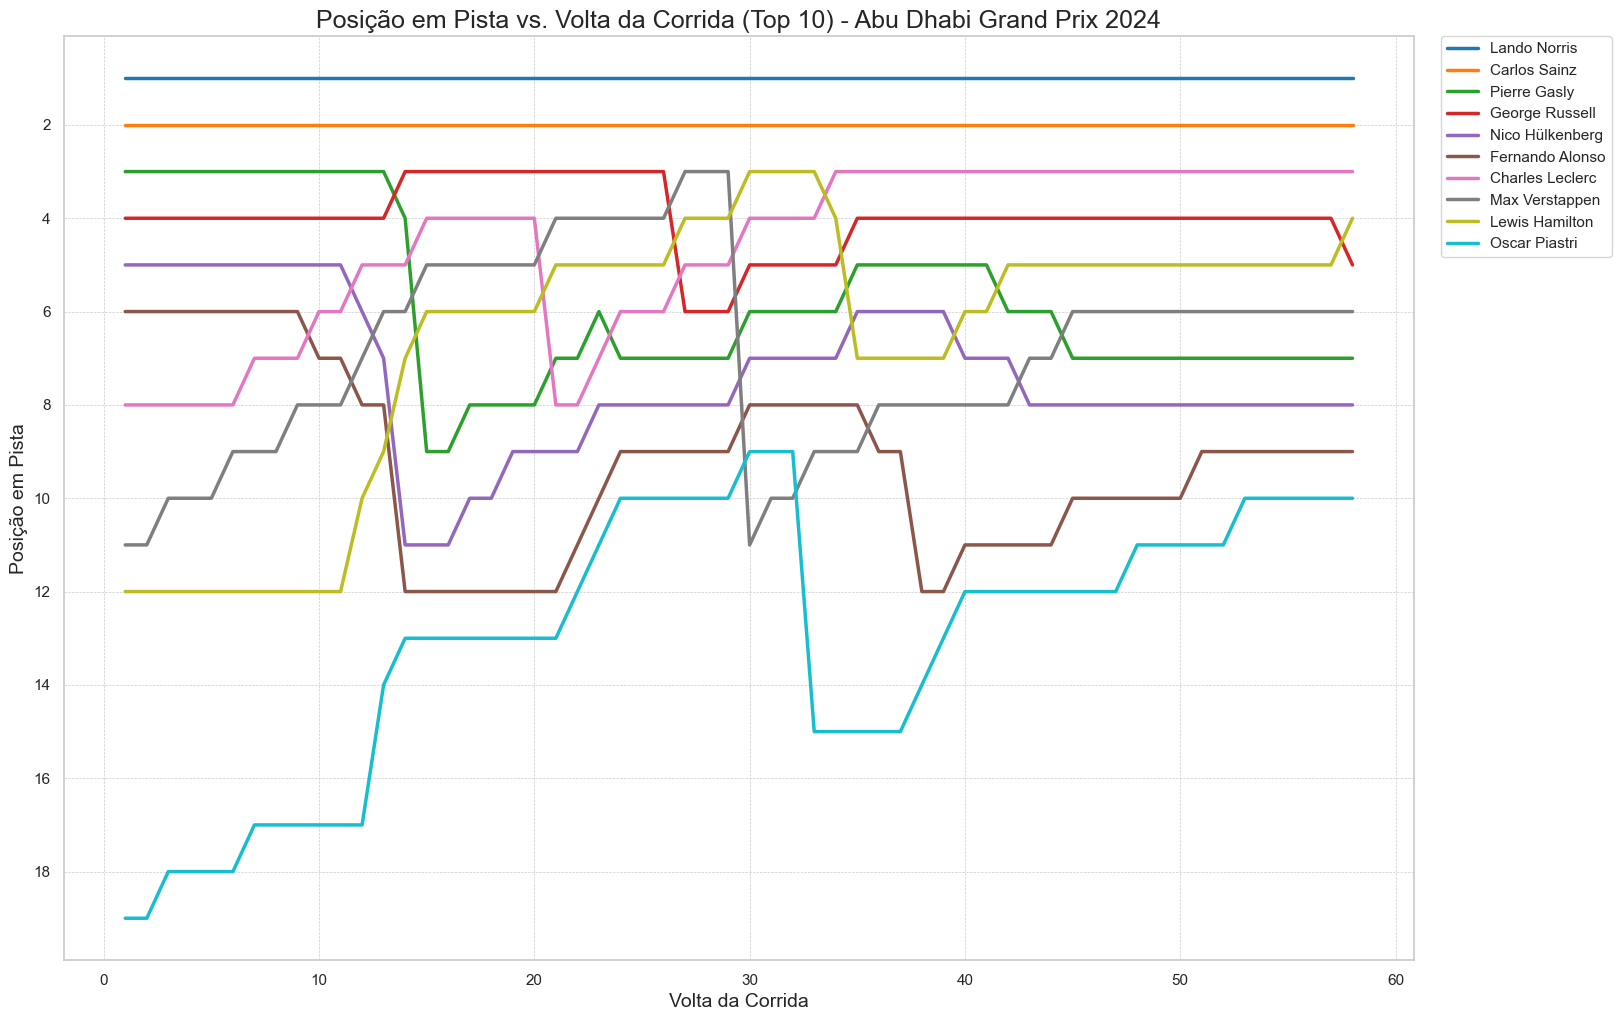

In [111]:
target_race_df = dataframes['races'].filter((col("year") == 2024) & (col("round") == 24))

if target_race_df.count() == 0:
    print("AVISO: Corrida para o ano de 2024, round 24, não encontrada. Gráfico 12 será pulado.")
else:
    target_race_info = target_race_df.select("raceId", "name").first()
    target_race_id = target_race_info['raceId']
    target_race_name = target_race_info['name']

    top_10_driver_rows = dataframes['results'] \
        .filter((col("raceId") == target_race_id) & (col("positionOrder") <= 10)) \
        .select("driverId") \
        .collect()
    top_10_driver_ids = [row['driverId'] for row in top_10_driver_rows]

    if not top_10_driver_ids:
        print(f"AVISO: Não há dados de resultado para a corrida '{target_race_name} 2024'. Gráfico 12 será pulado.")
    else:
        race_progression_df = dataframes['lap_times'] \
            .filter((col("raceId") == target_race_id) & col("driverId").isin(top_10_driver_ids)) \
            .join(dataframes['drivers'], "driverId") \
            .withColumn("driver_name", concat_ws(" ", col("forename"), col("surname"))) \
            .select("driver_name", "lap", "position")  

        plot_data_12 = race_progression_df.toPandas()

        if plot_data_12.empty:
            print(f"AVISO: Não há dados de tempo de volta para os pilotos da corrida '{target_race_name} 2024'. Gráfico 12 será pulado.")
        else:
            plt.figure(figsize=(20, 12))
            ax = sns.lineplot(
                data=plot_data_12,
                x='lap',  
                y='position',
                hue='driver_name',
                palette='tab10',
                linewidth=2.5
            )

            ax.invert_yaxis()
            ax.yaxis.set_major_locator(MaxNLocator(integer=True))
            
            ax.set_title(f'Posição em Pista vs. Volta da Corrida (Top 10) - {target_race_name} 2024', fontsize=18)
            ax.set_xlabel('Volta da Corrida', fontsize=14)
            ax.set_ylabel('Posição em Pista', fontsize=14)
            
            plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)
            plt.grid(True, which='both', linestyle='--', linewidth=0.5)
            plt.subplots_adjust(right=0.8)
            plt.show()

In [112]:
spark.stop()